# Initial EDA Report: Power Price Prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ETSModel
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "lines.linewidth": 2})

In [2]:
df = pd.read_csv('data/ail_price.csv', parse_dates=['date'], index_col='date')

In [3]:
df.index.is_monotonic_increasing

False

In [4]:
df = df.sort_values(by='date')

In [5]:
df.isnull().sum()

Unnamed: 0        0
hourly_profile    0
season            0
ail               0
gas_price         0
price             0
spark_spread      0
dtype: int64

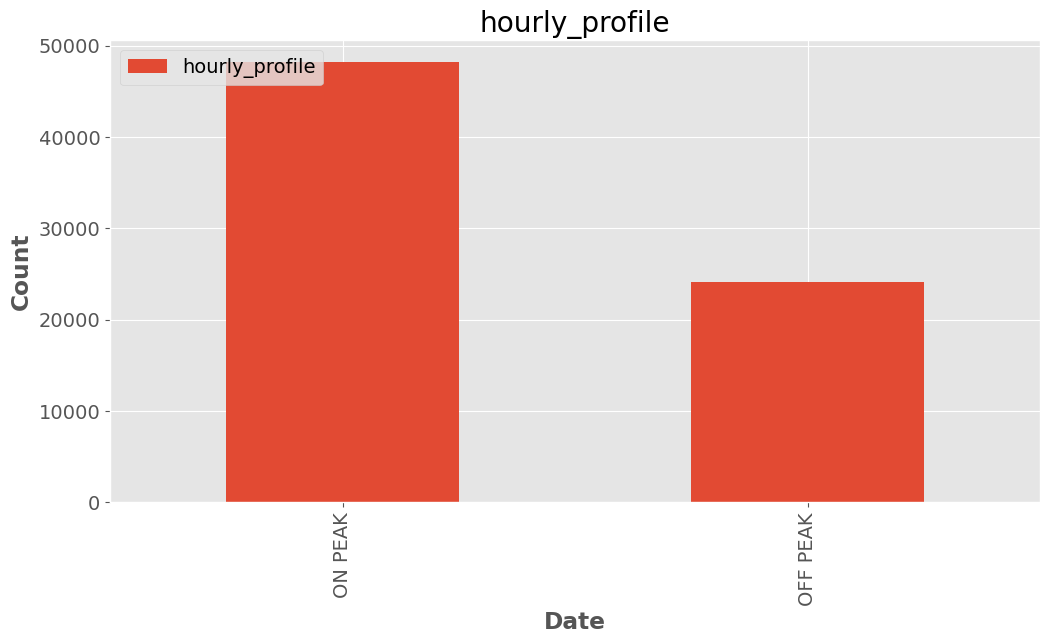

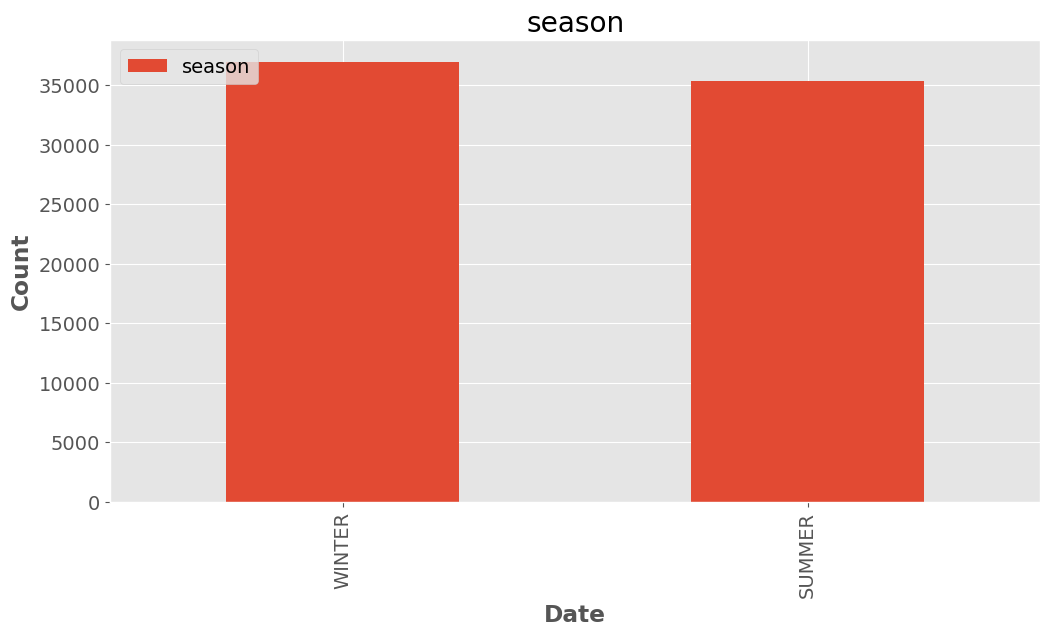

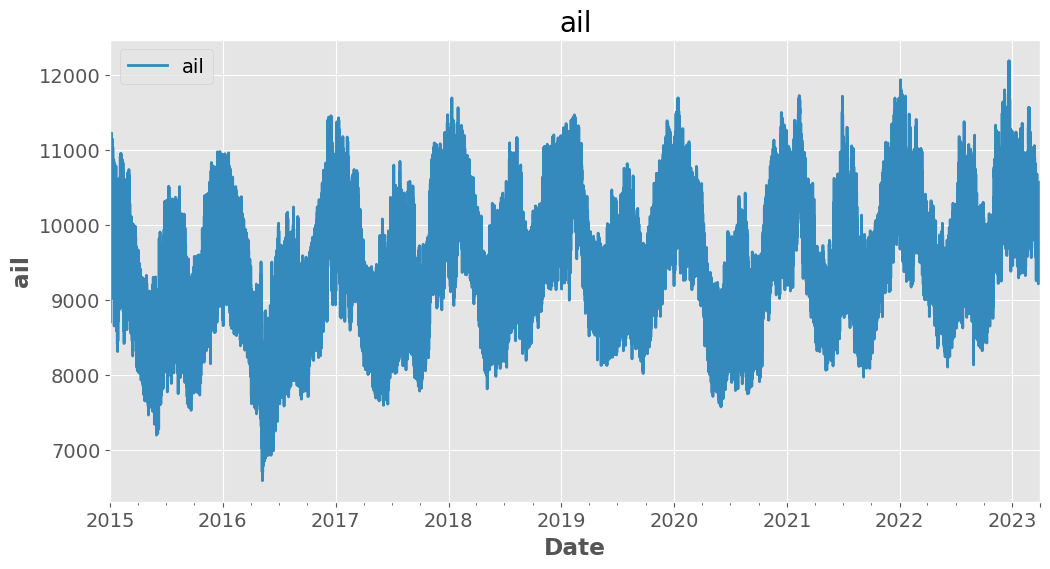

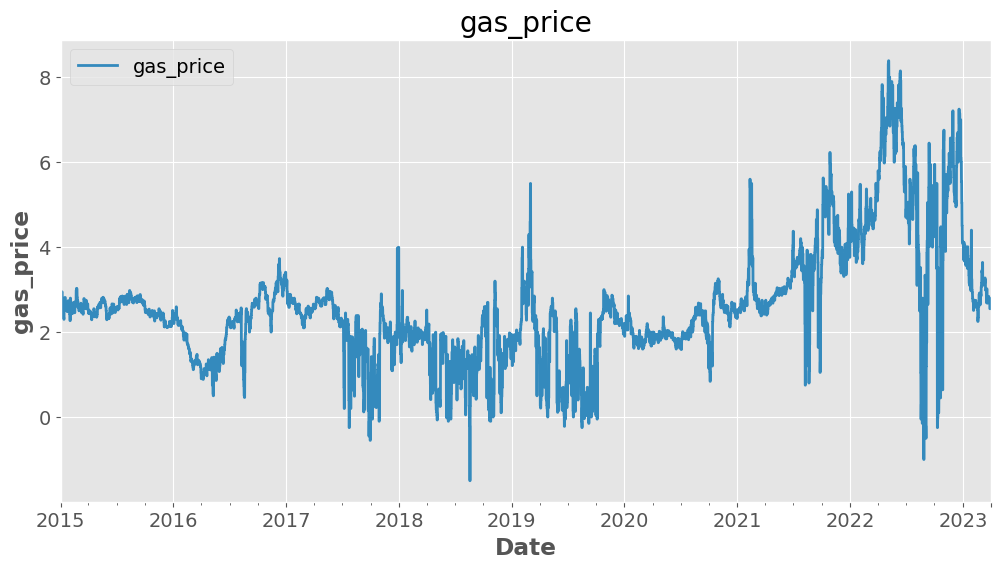

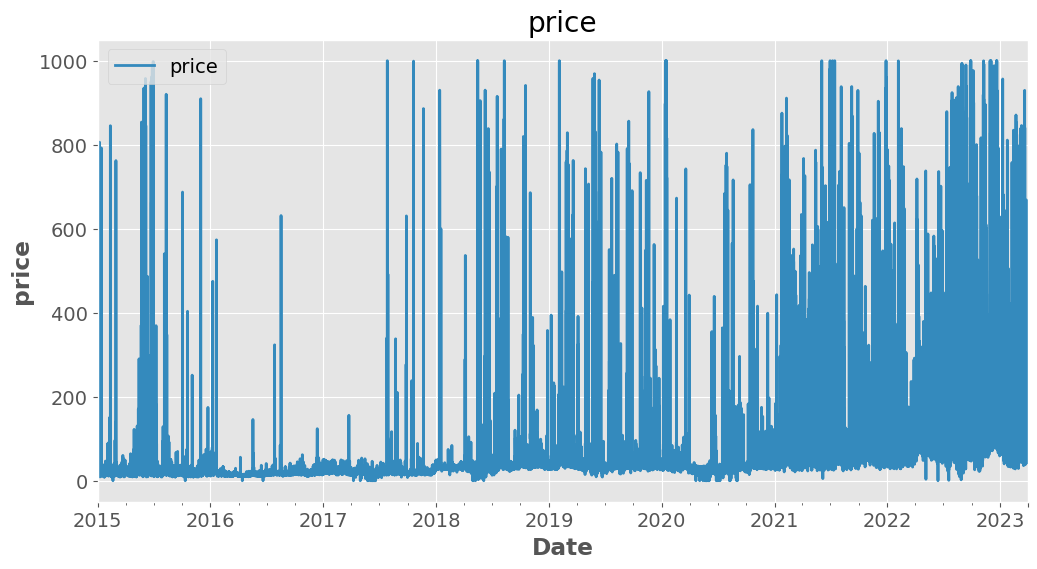

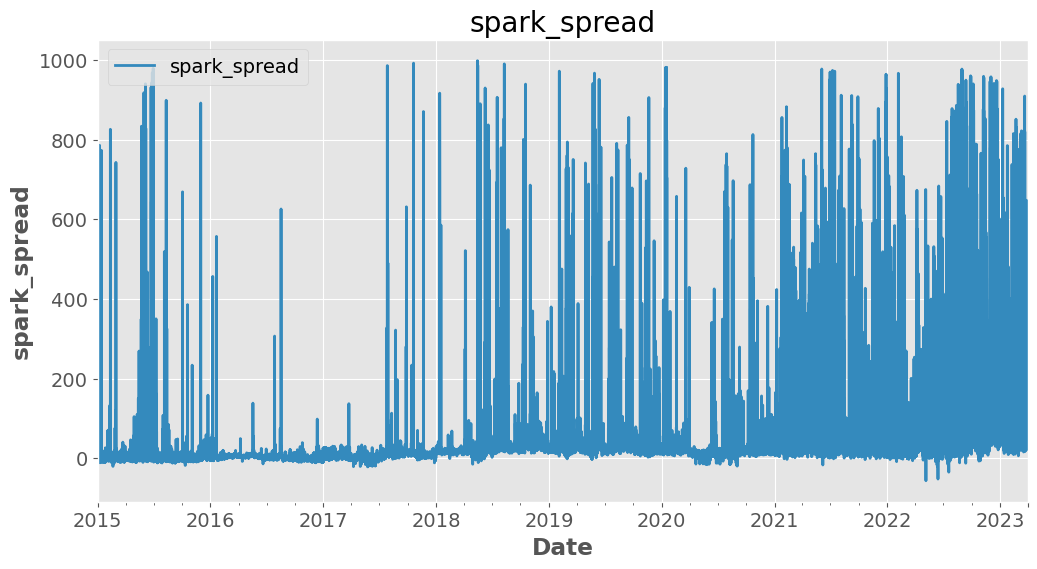

In [6]:
categorical_features = ['hourly_profile', 'season']
continuous_features = ['ail', 'gas_price', 'price', 'spark_spread']

for col in categorical_features:
    fig, ax = plt.subplots(figsize=(12, 6))
    df[col].value_counts().plot(kind='bar', ax=ax, label=col, color='C0')
    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    ax.set_title(col)
    ax.legend(loc='upper left')
    plt.show()

for col in continuous_features:
    fig, ax = plt.subplots(figsize=(12, 6))
    df[col].plot(ax=ax, label=col, color='C1')
    ax.set_xlabel('Date')
    ax.set_ylabel(col)
    ax.set_title(col)
    ax.legend(loc='upper left')
    plt.show()

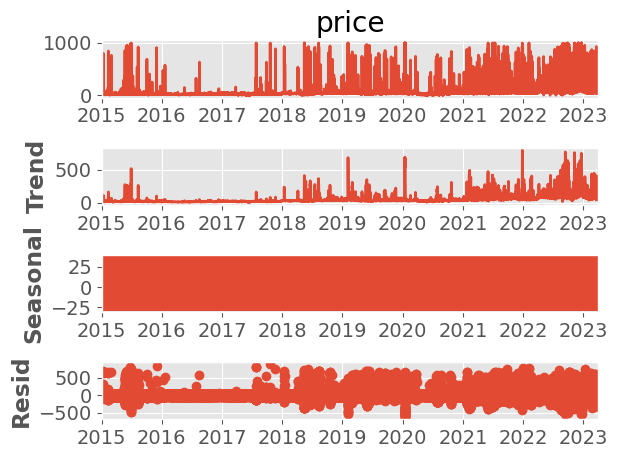

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform time series decomposition
result = seasonal_decompose(df['price'], model='additive', period=24)

# Plot the decomposition
result.plot();

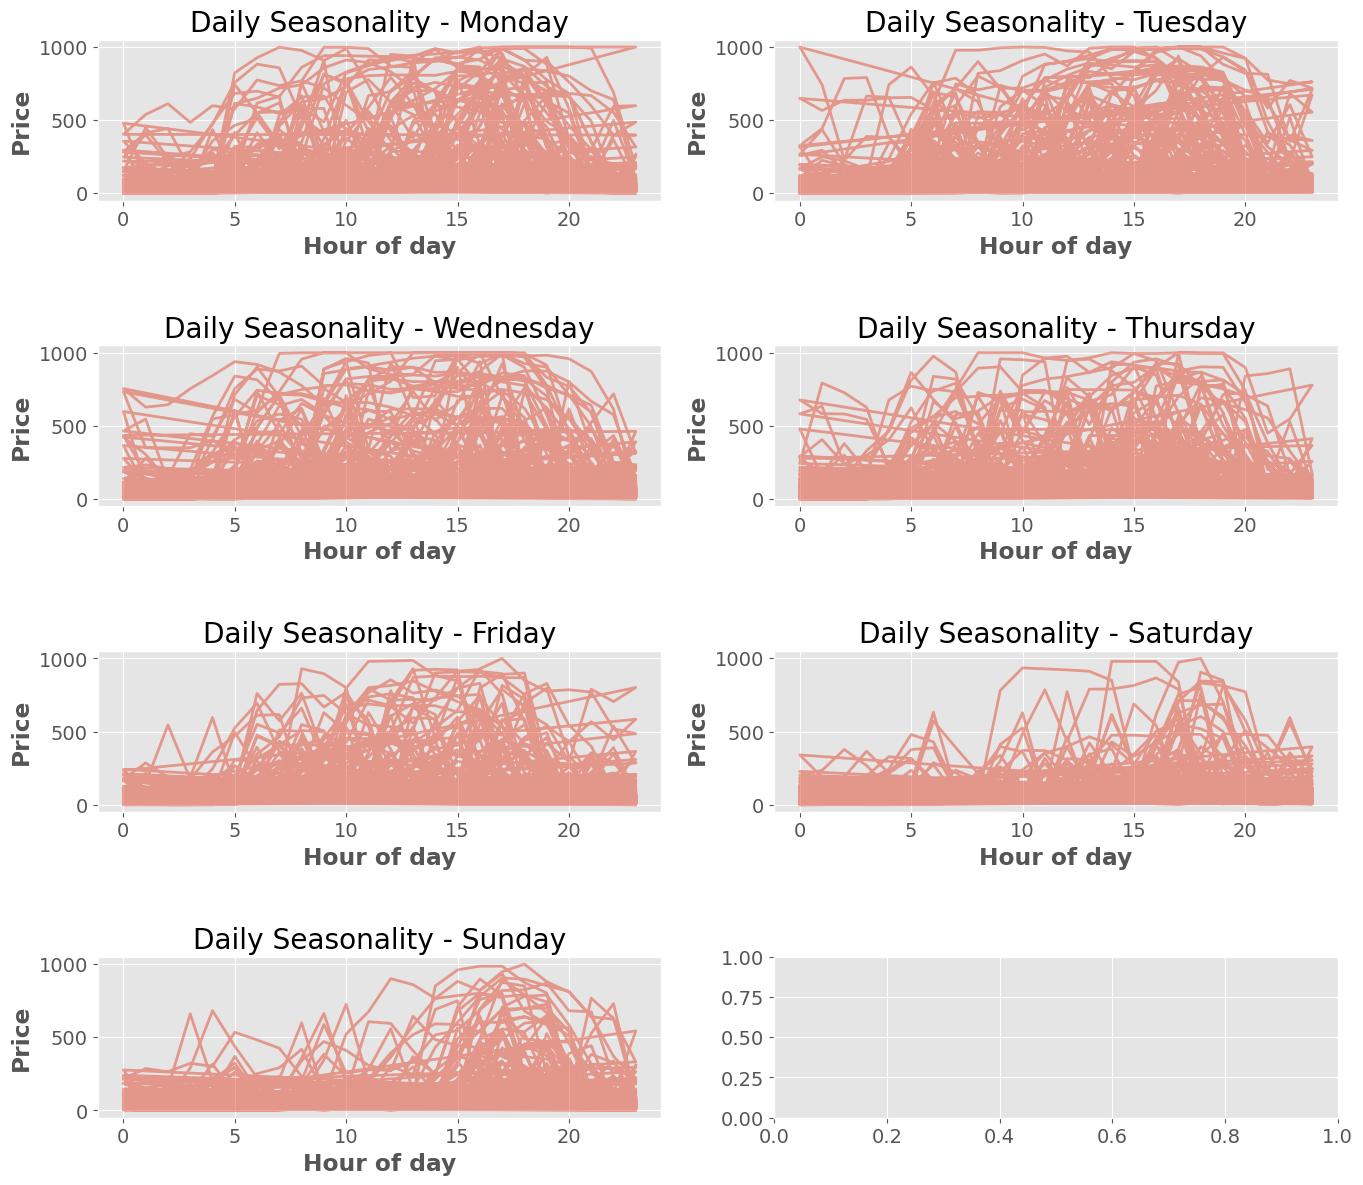

In [8]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 14))
plt.subplots_adjust(hspace=0.9)

# Loop through days of the week and plot data
for i, ax in enumerate(axs.flat):
    if i > 6:
        break

    day = df[df.index.dayofweek == i]
    ax.plot(day.index.hour, day['price'], alpha=0.5)
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Price')
    ax.set_title(f'Daily Seasonality - {day.index[0].strftime("%A")}')
    
plt.show()

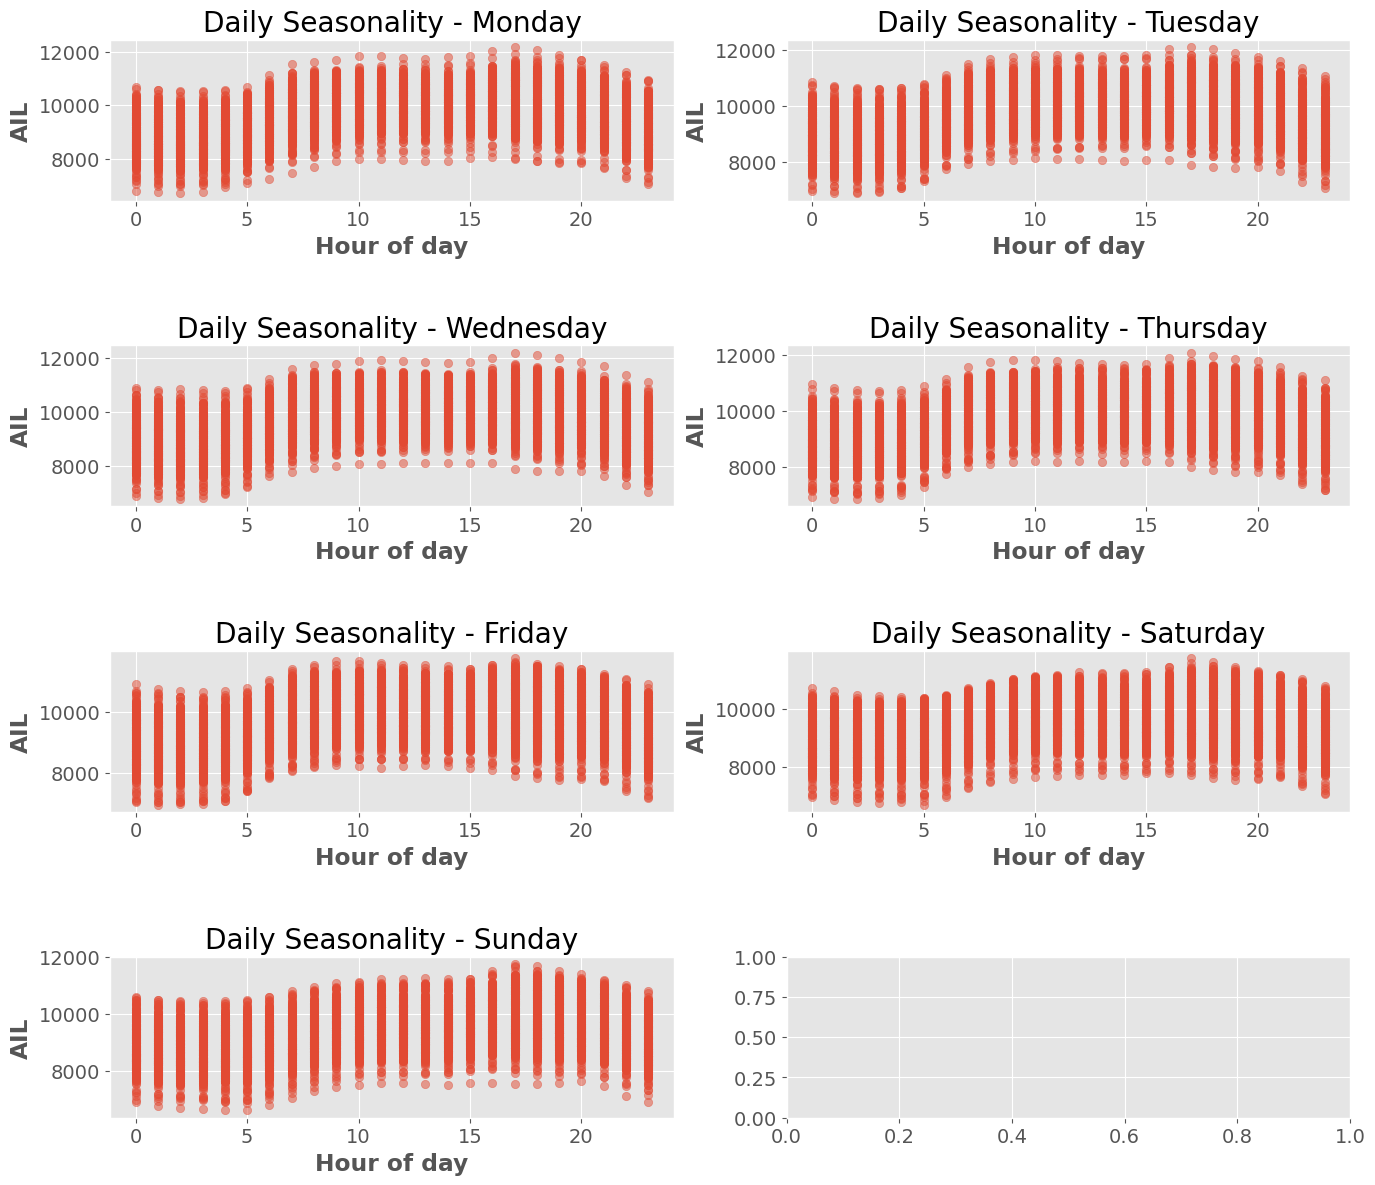

In [9]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 14))
plt.subplots_adjust(hspace=0.9)

# Loop through days of the week and plot data
for i, ax in enumerate(axs.flat):
    if i > 6:
        break

    day = df[df.index.dayofweek == i]
    ax.scatter(day.index.hour, day['ail'], alpha=0.5)
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('AIL')
    ax.set_title(f'Daily Seasonality - {day.index[0].strftime("%A")}')

plt.show()

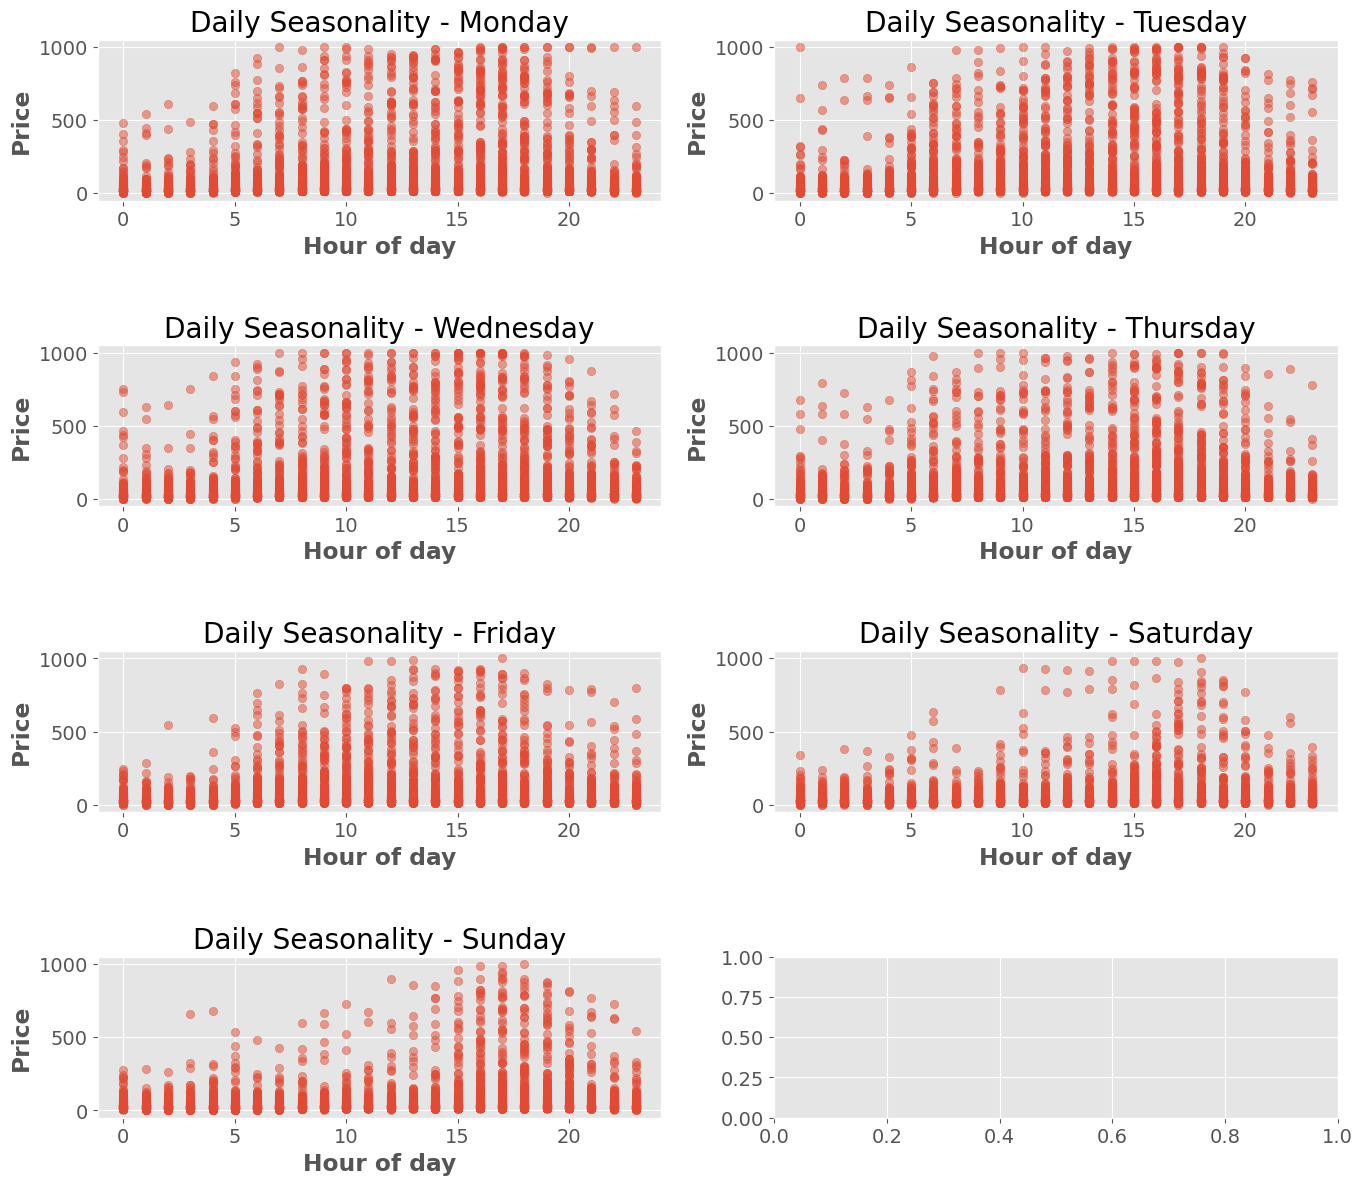

In [10]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 14))
plt.subplots_adjust(hspace=0.9)

# Loop through days of the week and plot data
for i, ax in enumerate(axs.flat):
    if i > 6:
        break

    day = df[df.index.dayofweek == i]
    ax.scatter(day.index.hour, day['price'], alpha=0.5)
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Price')
    ax.set_title(f'Daily Seasonality - {day.index[0].strftime("%A")}')

plt.show()

In [11]:
df_daily = df.resample('D').mean()

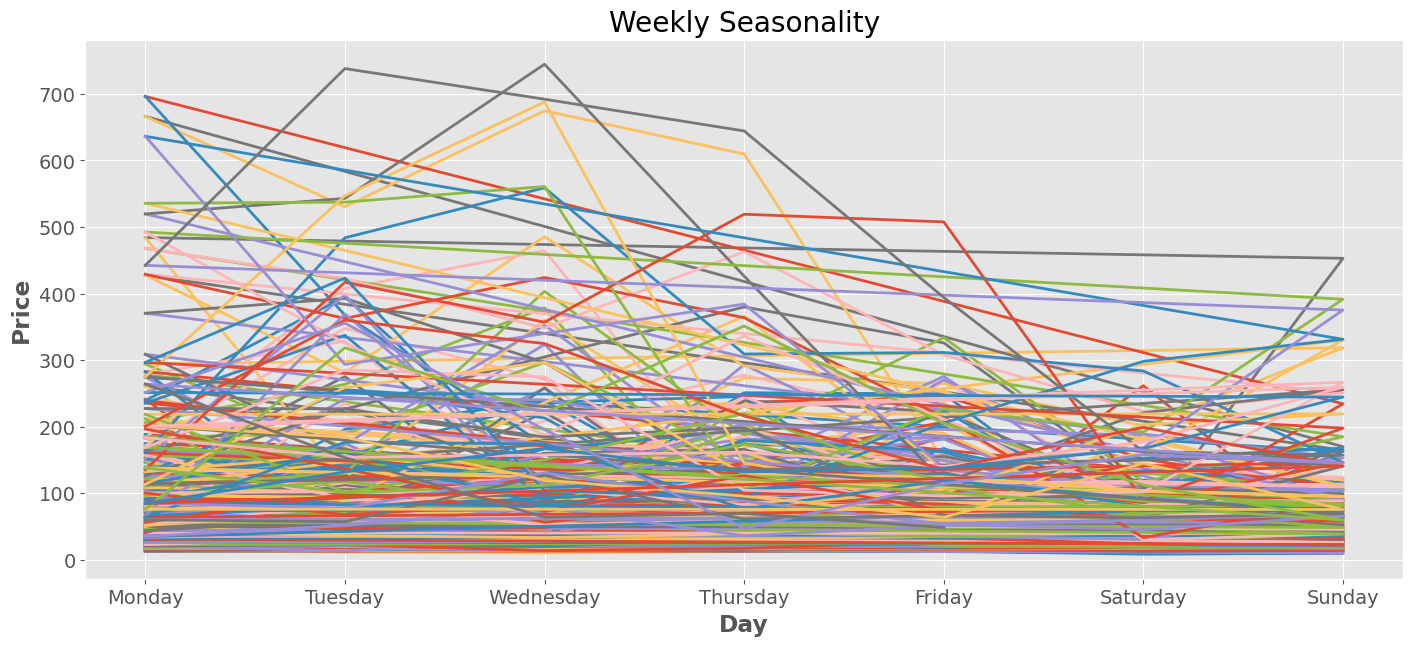

In [12]:
daily_price = df_daily

fig, ax = plt.subplots(figsize=(17, 7))

start = 0
end = 4

week = daily_price.iloc[start:end]
ax.plot(week.index.dayofweek, week['price'])

while end < len(daily_price):
    start = end
    end = min(start + 7, len(daily_price) - 1)
    week = daily_price.iloc[start:end+1]
    ax.plot(week.index.dayofweek, week['price'])
    if end == len(daily_price) - 1:
        break

ax.set_xticks(range(7))
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_xlabel('Day')
ax.set_ylabel('Price')
ax.set_title('Weekly Seasonality')
plt.show()

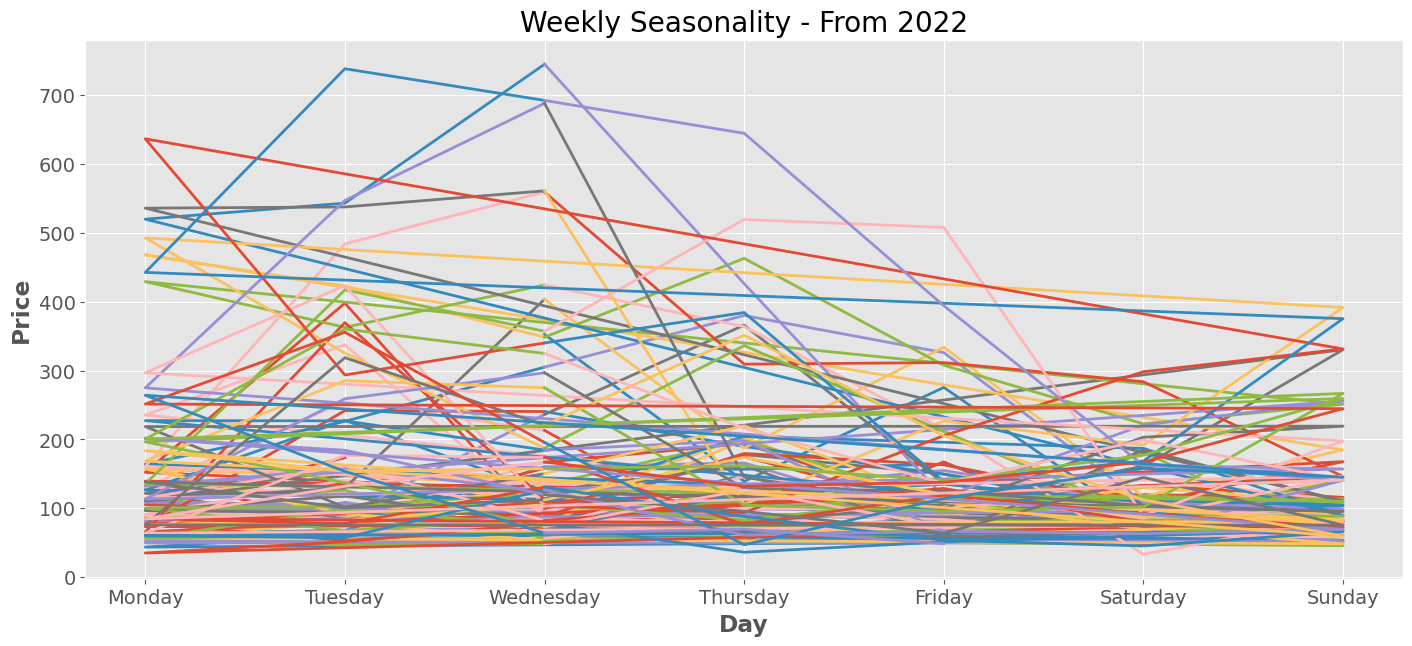

In [13]:
daily_price = df_daily.loc['2022':]

fig, ax = plt.subplots(figsize=(17, 7))

start = 0
end = 4

# Plot the first week from Tuesday to Sunday
week = daily_price.iloc[start:end]
ax.plot(week.index.dayofweek, week['price'])

while end < len(daily_price):
    start = end
    end = min(start + 7, len(daily_price) - 1)
    week = daily_price.iloc[start:end+1]
    ax.plot(week.index.dayofweek, week['price'])
    if end == len(daily_price) - 1:
        break

ax.set_xticks(range(7))
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_xlabel('Day')
ax.set_ylabel('Price')
ax.set_title('Weekly Seasonality - From 2022')
plt.show()


In [14]:
monthly_price = df.resample('M').mean() 

In [15]:
monthly_price.head(20)

,Unnamed: 0,ail,gas_price,price,spark_spread
date,,,,,
2015-01-31,36338.068548,9819.862903,2.626887,33.949530,14.247876
2015-02-28,36314.898810,9764.227679,2.639554,32.833720,13.037068
2015-03-31,38724.241935,9347.393817,2.596304,20.645726,1.173448
2015-04-30,38316.152778,8709.834722,2.427389,20.521500,2.316083
2015-05-31,18043.588710,8377.823925,2.642769,53.936734,34.115968
2015-06-30,17398.270833,8784.319444,2.492444,97.330681,78.637347
2015-07-31,18420.029570,9163.252688,2.715840,23.124261,2.755460
2015-08-31,18800.083333,9099.536290,2.802453,34.113347,13.094950
2015-09-30,18504.888889,8669.772222,2.743771,20.839333,0.261052


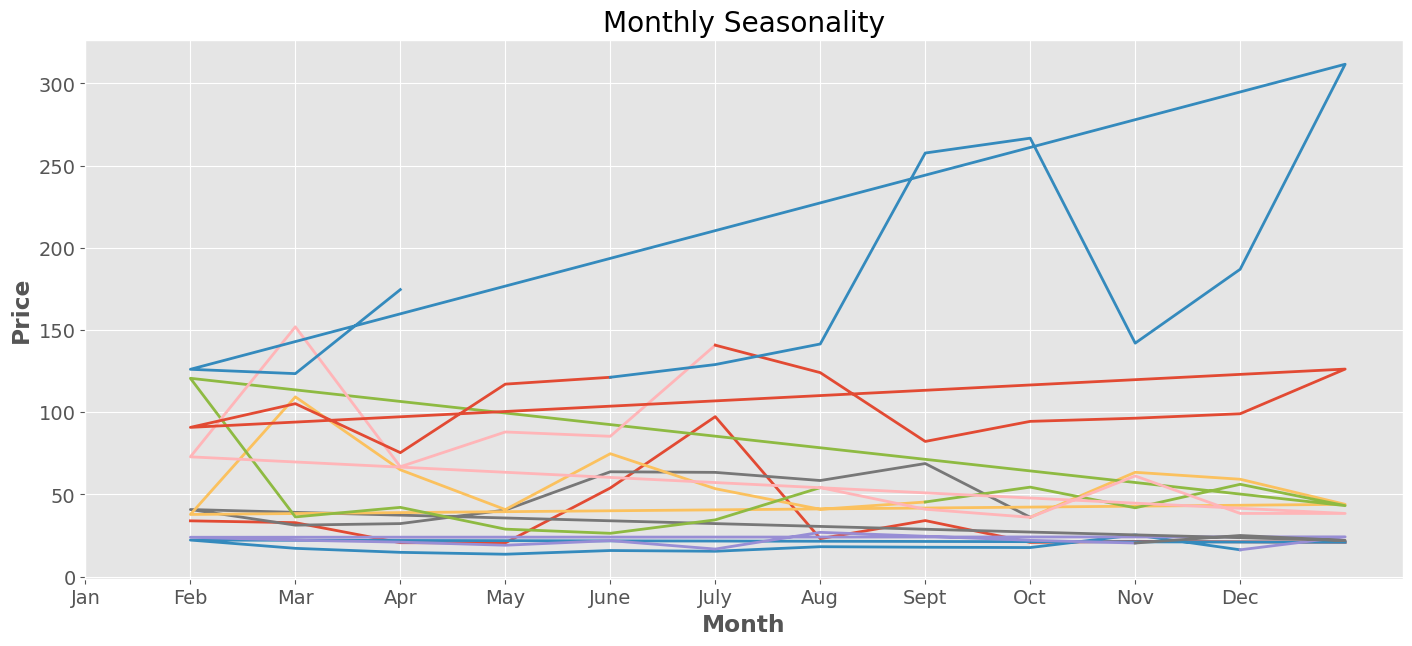

In [16]:
monthly_price = df.resample('M').mean() 

fig, ax = plt.subplots(figsize=(17, 7))
end = 0
start = 0

while end < len(monthly_price):
    start = end
    
    end = min(start + 11, len(monthly_price) - 1)

    month = monthly_price.iloc[start:end+1]

    ax.plot(month.index.month, month['price'])
    if end == len(monthly_price) - 1:
        break

ax.set_xticks(range(12))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('Month')
ax.set_ylabel('Price')
ax.set_title('Monthly Seasonality')
plt.show()


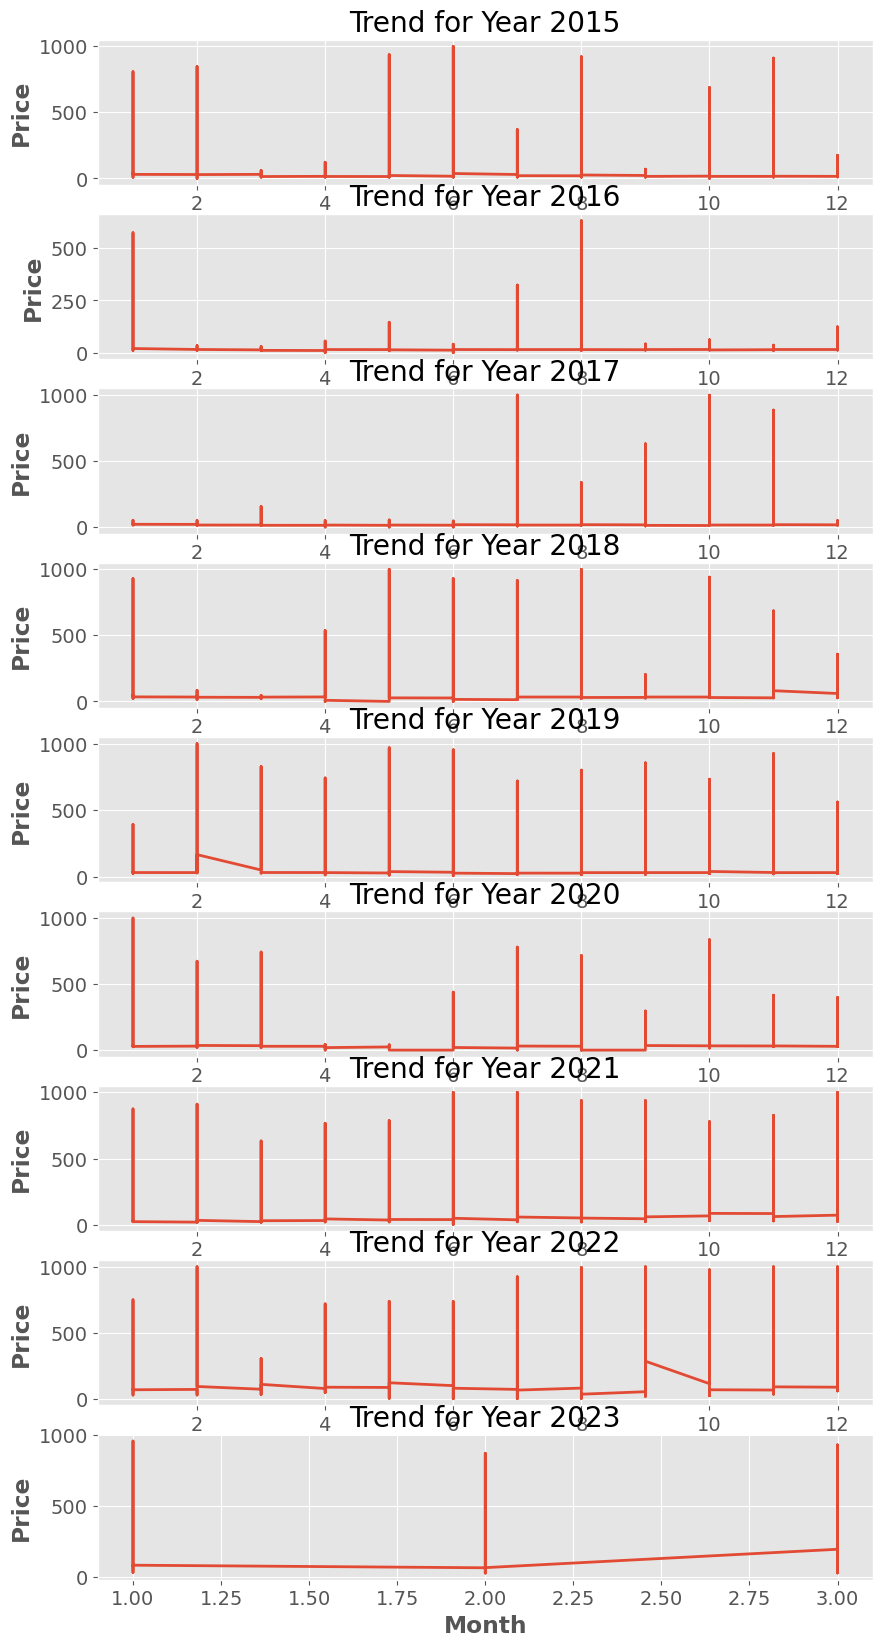

In [17]:
df_yearly = df.groupby(df.index.year)

# Create subplots for each year
fig, axs = plt.subplots(nrows=len(df_yearly), ncols=1, figsize=(10, 20))

# Plot the trend for each year
for i, (year, data) in enumerate(df_yearly):
    ax = axs[i]
    ax.plot(data.index.month, data['price'])
    ax.set_xlabel('Month')
    ax.set_ylabel('Price')
    ax.set_title(f'Trend for Year {year}')


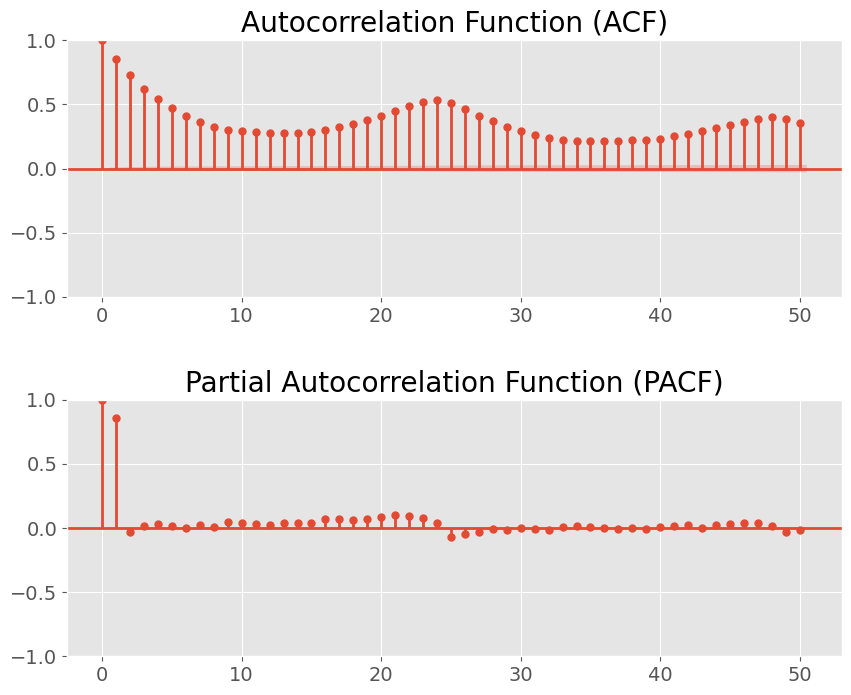

In [18]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_acf, seasonal_plot, month_plot


# Plot the ACF and PACF plots
fig, axs = plt.subplots(nrows=2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)

# ACF plot
plot_acf(df['price'], lags=50, ax=axs[0])
axs[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(df['price'], lags=50, ax=axs[1])
axs[1].set_title('Partial Autocorrelation Function (PACF)')

plt.show()

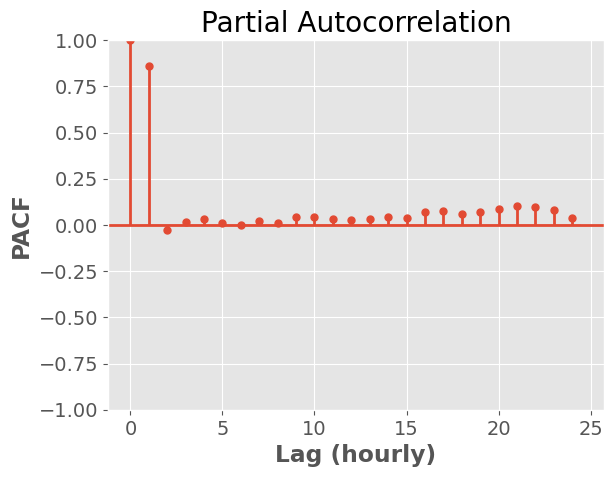

In [19]:
fig = plot_pacf(df["price"], lags=24)
plt.ylabel("PACF")
plt.xlabel("Lag (hourly)");

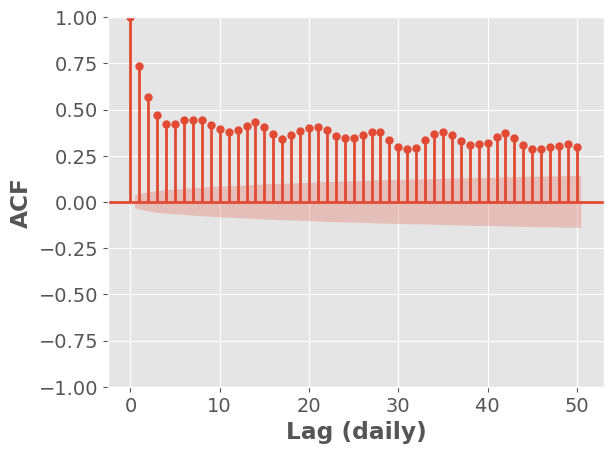

In [20]:
fig = plot_acf(df["price"].resample("D").mean(), lags=50, title=None, bartlett_confint=True)
plt.ylabel("ACF")
plt.xlabel("Lag (daily)");

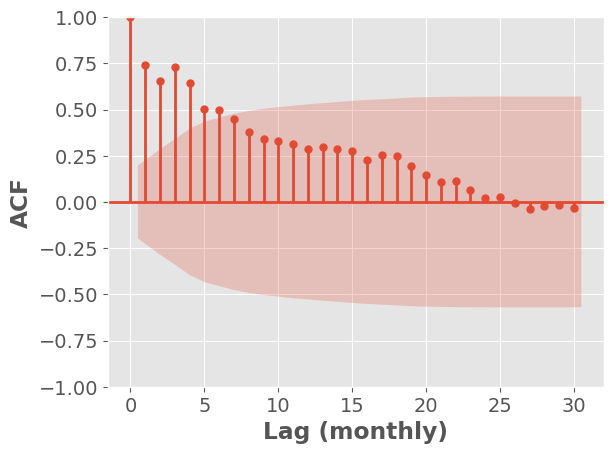

In [21]:
fig = plot_acf(df["price"].resample("M").mean(), lags=30, title=None, bartlett_confint=True)
plt.ylabel("ACF")
plt.xlabel("Lag (monthly)");